In [ ]:
!pip install DMBA mord

In [ ]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
import math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import GridSearchCV
from dmba import classificationSummary
from sklearn.model_selection import cross_val_score
print(sys.version)
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

Colab environment detected.
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
The scikit-learn version is 1.5.2.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA = Path('/content/drive/My Drive/Colab Notebooks/Analytics Competition/')

In [ ]:
train_X = pd.read_csv(DATA / 'train_X.csv')
valid_X = pd.read_csv(DATA / 'valid_X.csv')
train_y = pd.read_csv(DATA / 'train_y.csv')
valid_y = pd.read_csv(DATA / 'valid_y.csv')

train_X.head()

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,GrAppv,Franchise_Dummy,RevLineCr_N,...,State_TN,State_VT,State_WA,State_WI,State_WV,IndustryCode_Other,IndustryCode_Real_Estate,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,1996,84,8,0,0,85000.0,0.0,85000.0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,2002,84,7,1,7,50000.0,0.0,50000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2005,68,11,0,0,150000.0,0.0,150000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2005,69,15,0,15,11600.0,0.0,11600.0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1999,240,14,7,7,221000.0,0.0,221000.0,0,1,...,0,0,0,0,0,0,0,1,0,0


Average Net Profit (U.S. dollars)

| Actual \ Predicted | Paid in full (grant the loan) | Default (deny the loan) |
|-------------------|--------------------------------|--------------------------|
| Paid in full      | 5% of DisbursementGross        | 0                       |
| Default           | -5 times 5% of DisbursementGross | 0                       |

Before moving forward, it is crucial to discuss accuracy measures and which apply to our context in balancing misclassification costs and maximizing profit. The table above provided by the competition prompt, explains the profit or loss based on True Postitvies, True Negatives, False Postitives, and False negatives.

**True Positive:** The model predicting a loan will default when it actually does. This highlights the cost associated with a defaulted loan (which is 5 times the potential profit).

**True Negative:** The model predicts PIF and the loan is actually PIF. This results in no loss of profit, meaning it is a low-priority measure.

**False Positive:** The model predicts default but the customer PIF. This is simply a loss of profit. When applying the model to future data, this would result in the loss of income of 5% of the loan amount.

**False Negative:** The model predicts PIF but the customer actually defaulted. If we were to apply this model to future loans, this case would be a huge loss in which a loan is approved which will default. This is because the model has incorrectly classified a high-risk borrower as low-risk. The resulting default could cause loss for the lender, potentially equal to -5 times (5% of DisbursementGross) as indicated in the table provided. For this reason, this should be a priority accuracy measure for all modeling moving forward.

Accuracy Mesaures Calculation based on Confusion Matrix:

| Actual Class \ Predicted Class | Predicted Class 0 | Predicted Class 1 |
|--------------------------------|-------------------|-------------------|
| Actual Class 0                 | a                 | b                 |
| Actual Class 1                 | c                 | d                 |


| Metric                      | Formula                         |
|-----------------------------|----------------------------------|
| Accuracy                   | (a + d) / (a + b + c + d)       |
| Sensitivity (Recall)       | d / (c + d)                     |
| Specificity                | a / (a + b)                     |
| Precision                  | d / (b + d)                     |
| F1 Score                   | 2 * d / (2 * d + b + c)         |


| Metric                      | What It Indicates                                              | How to Interpret                                          |
|-----------------------------|---------------------------------------------------------------|----------------------------------------------------------|
| Accuracy                   | Overall correctness of the model.                              | Higher values indicate better overall performance.       |
| Sensitivity (Recall)       | Ability to correctly identify positive cases.                  | High sensitivity means few false negatives.              |
| Specificity                | Ability to correctly identify negative cases.                  | High specificity means few false positives.              |
| Precision                  | Proportion of predicted positives that are correct.            | High precision means fewer false alarms (false positives).|
| F1 Score                   | Balance between precision and recall.                          | High F1 score indicates good balance between precision and recall. |


**F1 Score**

**For our entire analysis, we will be prioritizing f1 score. This accuracy measure balances the financial consequnces of approving a loan that would default and also denying a loan that wouldve PIF. This balance is cruical to maximisng profit and creating a realistic cut-off for future loan data**

**Decision trees**: provide valuable insight into the importance of features. Decision trees typically offer value through their clear visual interpretability. However, highly dimensional data like loan data we have been provided can be difficult to visualize. There are still methods to determine a feature's relative importance to a model using the methods. Utilizing this insight is necessary for further modeling methods such as KNN with huge computational demands. Any means of reducing the complexity of our data will aid in the reduction of computational time and ability which is tricky for students operating on our on hardware.

**Criterion:** A criterion determines how the algorithm will determine the best way to split the data at each node of the tree we produce. When utilizing DecisionTreeClassifier, you must determine which criterion you will use, "Gini" or "Entropy". Both measure the impurity of a data set and aim to create more pure subsets. Entropy will try to create subsets where most loans either PIF or default, making the prediction clearer. Gini focuses on minimizing the probability of misclassifying a loan if it were Randomly assigned a class label based on the distribution within the subset. Overall Gini is more efficient computationally and using Entropy can be quite time-consuming for a data set this large. Overall it is important to compare our results with both to truly determine what is better suited.

**Single Tree**

This single tree decision classfier acts as a baseline model from which we can compare the preformance of the more complex methods we will be applying later (Bagging, Boosting, Random Forest).

In [ ]:
defaultTree = DecisionTreeClassifier(criterion="gini")
defaultTree.fit(train_X, train_y)

classes = defaultTree.classes_
classificationSummary(valid_y, defaultTree.predict(valid_X), class_names=defaultTree.classes_)
y_pred = defaultTree.predict(valid_X)
f1 = f1_score(valid_y, y_pred)
print(f"F1 Score: {f1}")

Confusion Matrix (Accuracy 0.9208)

       Prediction
Actual      0      1
     0 282232  14470
     1  14013  48951
F1 Score: 0.7746330656327887


Recall

-


48804/(13778+49186) = 0.7751

In [ ]:
defaultTree = DecisionTreeClassifier(criterion="entropy")
defaultTree.fit(train_X, train_y)

classes = defaultTree.classes_
classificationSummary(valid_y, defaultTree.predict(valid_X), class_names=defaultTree.classes_)
y_pred = defaultTree.predict(valid_X)

f1 = f1_score(valid_y, y_pred)
print(f"F1 Score: {f1}")

Confusion Matrix (Accuracy 0.9221)

       Prediction
Actual      0      1
     0 282473  14229
     1  13779  49185
F1 Score: 0.7783791482694773


Recall

-


49186/(13778+49186) = 0.7812

**Bagging**

"Bagging" is short for Boostrap aggrgation. Bootstrapping will create subsets from the training data we have created randomly. This means certain data might repeat and some might not appear at all. Bagging combines predictions from these many mini models created from our training data. The method aims to reduce variance, which in turn can imrove overall prediction accuracy. In the code, you see "n_estimators = x". This determines the amount of mini models or mini trees to be created. The more created typically helps the model more up to a certain threshold. However it can be computationally intense to experiment with out limited hardware, so we will stick with a common starting point of 100. In a scenario fine tuning a model, it would be important to experiment for best results.

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(criterion="gini"),
                            n_estimators=100, random_state=1)
bagging.fit(train_X, train_y)
classificationSummary(valid_y, bagging.predict(valid_X), class_names=classes)
y_pred = bagging.predict(valid_X)
f1 = f1_score(valid_y, y_pred)
print(f"F1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix (Accuracy 0.9453)

       Prediction
Actual      0      1
     0 287521   9181
     1  10485  52479
F1 Score: 0.8421973295673385


Recall

-


52479/(10485+52479) = 0.8334

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(criterion="entropy"),
                            n_estimators=100, random_state=1)
bagging.fit(train_X, train_y)
classificationSummary(valid_y, bagging.predict(valid_X), class_names=classes)
y_pred = bagging.predict(valid_X)
f1 = f1_score(valid_y, y_pred)
print(f"F1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix (Accuracy 0.9464)

       Prediction
Actual      0      1
     0 287544   9158
     1  10107  52857
F1 Score: 0.8458541034893862


Recall

-

52857/(10107+52857) = 0.8351

**Boosting**

Boosting is another ensemble technique like bagging but differs in approach. Boosting trains sample models sequentially. This means that each subsquent model will learn from the previous one built before it. Bagging simply combines the base estimator predcitions but boosting assigns higher weights based on their performance.

In [ ]:
boost = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini"), n_estimators=100, random_state=1)
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X), class_names=classes)
y_pred = boost.predict(valid_X)
f1 = f1_score(valid_y, y_pred)
print(f"F1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix (Accuracy 0.9242)

       Prediction
Actual      0      1
     0 283369  13333
     1  13947  49017
F1 Score: 0.7823068452048454


Recall


-

49017/(13947+49017)= 0.7784



In [ ]:
boost = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy"), n_estimators=100, random_state=1)
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X), class_names=classes)
y_pred = boost.predict(valid_X)
f1 = f1_score(valid_y, y_pred)
print(f"F1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix (Accuracy 0.9271)

       Prediction
Actual      0      1
     0 283639  13063
     1  13161  49803
F1 Score: 0.7915918302471588


Recall


-


49803/(13161+49803) = 0.791

**Random Forest**

The final ensemble method we will compare RandomForestClassifier. A "random forest" of decsion trees are trained from various subests of the training data. The randomness halps reduce correlation between stress and prevents over fitting. Due to this, I will also be displaying the feature importances from this Random Forest as a means of dropping more insignificant predictors.

In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y['Default_CHGOFF'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

classificationSummary(valid_y['Default_CHGOFF'], rf.predict(valid_X))
y_pred = rf.predict(valid_X)

f1 = f1_score(valid_y['Default_CHGOFF'], y_pred)
print(f"F1 Score: {f1}")

                 feature  importance       std
20     State_NJ_SC_NY_MD    0.000000  0.000000
23     State_UT_WY_ND_SD    0.000000  0.000000
22        State_CO_IN_MA    0.000000  0.000000
21  State_TX_CA_DE_KY_VA    0.000000  0.000000
19           State_IL_MI    0.000000  0.000000
..                   ...         ...       ...
2                  NoEmp    0.049137  0.003356
7                 GrAppv    0.078085  0.010435
5      DisbursementGross    0.083154  0.007486
0             ApprovalFY    0.117684  0.016917
1                   Term    0.439116  0.024415

[67 rows x 3 columns]
Confusion Matrix (Accuracy 0.9370)

       Prediction
Actual      0      1
     0 289461   7241
     1  15417  47547
F1 Score: 0.8075786398532508


Recall


-

47547/(15417+47547) = 0.751



Feature Importance:

In [ ]:
df
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,feature,importance,std
20,State_NJ_SC_NY_MD,0.000000,0.000000
23,State_UT_WY_ND_SD,0.000000,0.000000
22,State_CO_IN_MA,0.000000,0.000000
21,State_TX_CA_DE_KY_VA,0.000000,0.000000
19,State_IL_MI,0.000000,0.000000
18,State_GA_NV,0.000000,0.000000
6,BalanceGross,0.000006,0.000008
17,NewExist_Other,0.000139,0.000044
31,State_AK,0.000496,0.000091
36,State_DC,0.000500,0.000081


In [ ]:
df = df.sort_values('importance')
# Get the lowest 30 features
lowest_30_features = df.head(30)['feature']

# Calculate cumulative importance of the lowest 30 features
cumulative_importance = df.head(30)['importance'].sum()

# Drop the lowest 30 features from train_X, valid_X, and df
train_X.drop(columns=lowest_30_features, inplace=True)
valid_X.drop(columns=lowest_30_features, inplace=True)
df = df[~df['feature'].isin(lowest_30_features)]  # Drop from df as well

# Print the cumulative importance
print(f"Cumulative Importance of Lowest 30 Features: {cumulative_importance}")

Cumulative Importance of Lowest 30 Features: 0.030053006342193433


<Figure size 1200x800 with 0 Axes>

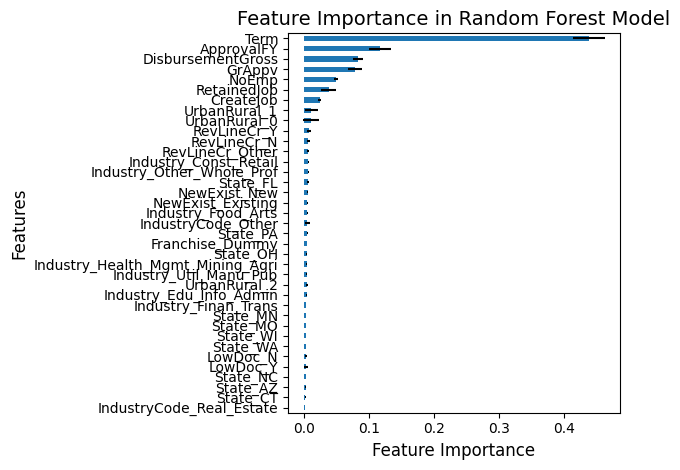

In [ ]:
plt.figure(figsize=(12, 8))
ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.tick_params(axis='y', labelsize=10)
plt.title('Feature Importance in Random Forest Model', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
lowest_30_features

,feature
20,State_NJ_SC_NY_MD
23,State_UT_WY_ND_SD
22,State_CO_IN_MA
21,State_TX_CA_DE_KY_VA
19,State_IL_MI
18,State_GA_NV
6,BalanceGross
17,NewExist_Other
31,State_AK
36,State_DC


**Pruning:**

Our best model was bagging with the critertion Entropy. To potentially further improve the model we can prune it. Pruning is good for preventing overfitting and building a more reliable prediction model. This is accomplish through limiting the "max_depth". This helps balance complexity and accuracy.The evaluation of predictor importance above is relevant to the Random Forest and was completed for reducing dimensionality in future models if neccessary. This pruning reduces the dimnesionality of our best preforming model for f1 Score.

In [ ]:
# Create a Bagging Classifier with pruned Decision Trees
bagging_pruned = BaggingClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=10),
                            n_estimators=100, random_state=1)

# Perform cross-validation using F1 score
scores = cross_val_score(bagging_pruned, train_X, train_y, cv=5, scoring='f1')

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average F1 score:", scores.mean())

# Train the model on the full training data for final predictions
bagging_pruned.fit(train_X, train_y)

# Make predictions on the validation set
y_pred = bagging_pruned.predict(valid_X)

# Print a classification summary for more detailed evaluation
classificationSummary(valid_y, y_pred, class_names=classes)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Cross-validation scores: [0.82059663 0.8252706  0.81980614 0.81701583 0.82476101]
Average F1 score: 0.82149004090546


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix (Accuracy 0.9403)

       Prediction
Actual      0      1
     0 288748   7954
     1  13521  49443


After pruning the model with various values for max_depth, the recall value fell, even with cross validation. It is possible with large amounts of experimentation that someone could prune well, but with limited computational ability, it is too labor intensive. For this reason, our original bagging model is still our first choice for our accuracy and F1score. We will use this model to determine the ideal cutoff value.

**Determining Cut Off Value:**

Now that we have determined our best decision tree model (bagging w/ entropy), we must calculate the best cutoff probability for predicting loan defaults. This inhernetly minimizes potential losses. We will calculate the probabilty of deafault (PD). We will balance the trade-off of apporving loans with high PD and rejecting good loans.

In [ ]:
best_cutoff = 0
best_f1_score = 0

for cutoff in np.arange(0.01, 1, 0.01):
    # Predictions using bagging
    predicted_probs = bagging.predict_proba(valid_X)[:, 1]
    predictions = (predicted_probs >= cutoff).astype(int)

    f1 = f1_score(valid_y['Default_CHGOFF'], predictions)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_cutoff = cutoff

print(f"Optimal Cut-off (F1-score): {best_cutoff}")
print(f"Best F1 Score: {best_f1_score}")

Optimal Cut-off (F1-score): 0.45
Best F1 Score: 0.847598120097905


###Conclusions

From The random forest classifier, we were able to collect information regarding feature importance. We will utilize this information when building future models with high computational needs. Reducing this dimensionality will aid our ability to better visualize future results and overall a better understanding of the features with great impact. Notable examples are Term, Approval Fiscal Year, and Disbursement Gross. These dropped bottom features only held 0.0301 of feature importance cumulatively. For other modeling techniques, we will only drop these predictors when necessary.

As we can see, Entropy overall improved both the accuracy and recall of our various ensemble methods. However, Bagging provided the highest accuracy and recall making it the obvious choice for future applications. By selecting the model with highest recall, we will minimize losses and maximize profit. However with our new understanding, we must exmperiment with other modeling straetgies.

The model suggests that to minimize losses and maximize profits, you should only grant loans to applicants where the model predicts a less than 55% chance of default. This would maximize profits and reduce risk. This cutoff point helps achieve a high f1 score balancing  between identifying potential defaults and avoiding unnecessary loan rejections.

# FINAL CHOOSEN MODEL

Review this portion after analyzing all other models

Based on a comparison of all modeling techniques and accuracy measures, the bagging model of the decision tree classifier performed all other models. This model will provide the highest net profit on this basis. Choosing this as our final model selection we will complete the following objectives

1) Use the estimated probabilities (propensities) from your chosen model as a basis for selecting the least risky loan application first, followed by more risky loan applications.

---

 2) Create a vector containing the net profit for each loan application in the validation set. Use this vector
to create gains and lift charts for the validation set that incorporates the net profit.

---

 3) How far into the validation data should you go to get maximum net profit?


---

4)  If this model is used to score to future loan applicants, what “probability of success” cut-off should be used in granting the loan and extending credit?


1)

In [ ]:
valid_X['PD'] = bagging.predict_proba(valid_X)[:, 1]

valid_X_sorted = valid_X.sort_values(by=['PD'], ascending=True)

least_risky_loan = valid_X_sorted.iloc[0]


2)

In [ ]:
valid_X['Net Profit'] = 0
valid_X.loc[(valid_y['Default_CHGOFF'] == 0) & (valid_X['PD'] < best_cutoff), 'Net Profit'] = 0.05 * valid_X.loc[(valid_y['Default_CHGOFF'] == 0) & (valid_X['PD'] < best_cutoff), 'DisbursementGross']  # Profit for correctly predicted PIF loans
valid_X.loc[(valid_y['Default_CHGOFF'] == 1) & (valid_X['PD'] >= best_cutoff), 'Net Profit'] = 0  # No profit for correctly predicted default loans
valid_X.loc[(valid_y['Default_CHGOFF'] == 0) & (valid_X['PD'] >= best_cutoff), 'Net Profit'] = 0  # No profit for incorrectly predicted default loans (false positive)
valid_X.loc[(valid_y['Default_CHGOFF'] == 1) & (valid_X['PD'] < best_cutoff), 'Net Profit'] = -0.25 * valid_X.loc[(valid_y['Default_CHGOFF'] == 1) & (valid_X['PD'] < best_cutoff), 'DisbursementGross']  # Loss for incorrectly predicted PIF loans (false negative)
net_profit_vector = valid_X['Net Profit'].values

gainsChart(net_profit_vector, figsize=[5, 5])
liftChart(net_profit_vector, figsize=[5, 5])

plt.show()


3)

In [ ]:
valid_X_sorted['Cumulative Profit'] = valid_X_sorted['Net Profit'].cumsum()
max_profit_index = valid_X_sorted['Cumulative Profit'].idxmax()

depth_into_data = max_profit_index + 1

print(f"Maximum net profit is achieved by granting loans to the first {depth_into_data} applicants in the sorted validation data.")


4) As we showed above, the optimal cutoff for maximizing net profit for futre loan predicitions using our best model (bagging Decision tree Classifier)
is **0.45**